In [167]:
# Config Data Structure
import pandas as pd
from datetime import datetime as dt
from pymongo import MongoClient as mc
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import pprint as pp
import random as ran
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN, LSTM
from tensorflow.keras.utils import to_categorical
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize': (15.7, 13.27)})
plt.rcParams['figure.figsize'] = 15.7,13.27
plt.rcParams['font.family'] = 'AppleGothic'

mongo_uri = "mongodb://localhost:27017"
client = mc(mongo_uri)
keti_db = client.keti_pattern_recognition

household_col = keti_db.household_info
cluster_col = keti_db.cluster_info
weather_col = keti_db.weather_info

In [190]:
uid = "아파트2-3-1002"

# TimeSlot In
hh_db_datas = household_col.find_one({"uid": uid})
hh_db_datas

uid_in, timeslot = hh_db_datas['uid'], hh_db_datas['timeslot']

datelist = [
    dt.strptime(ts['time'], "%Y-%m-%d T%H:%M %z").date()
    for ts in timeslot
]
datelist = list(set(datelist))
datelist.sort()

ts_datas = {}
start_idx = 0
end_idx = 96
enl = 1

for date in datelist:
    ts_datas[date] = [ts['power'] *
                      enl for ts in timeslot[start_idx:end_idx]]
    start_idx = end_idx
    end_idx = end_idx + 96

ts_datas = pd.DataFrame(ts_datas).T
hh_datas = ts_datas.reset_index().copy()

hh_datas.rename(columns={"index": "date"}, inplace=True)
hh_datas['date'] = pd.to_datetime(hh_datas['date'])

hh_datas.set_index('date', inplace=True)

# Merging
merge_size = 4
merge_datas = pd.DataFrame()
for date in hh_datas.index:
    merge_ts = []
    new_ts_size = round(len(hh_datas.loc[date]) / merge_size)
    
    for idx in range(0,new_ts_size):
        merge_ts.append(
            round(hh_datas.loc[date][merge_size * idx:merge_size * (idx + 1)].sum(), 3) * 1000
        )

    if len(list(set(merge_ts))) >= 3:
        merge_datas[date] = merge_ts
#     merge_datas[date] = merge_ts

    
def get_season_no(month):
    if month in [3,4,5]:
        return 1 # 봄
    elif month in [6,7,8]:
        return 2 # 여름
    elif month in [9,10,11]:
        return 3 # 가을
    elif month in [12,1,2]:
        return 4 # 겨울
    
separate_datas_col = list(filter(lambda data: get_season_no(data.month) == 3, merge_datas.columns))
# print(separate_datas_col)
merge_datas = merge_datas[separate_datas_col]
merge_datas

,2018-09-01,2018-09-02,2018-09-03,2018-09-04,2018-09-05,2018-09-06,2018-09-07,2018-09-08,2018-09-09,2018-09-10,...,2018-11-21,2018-11-22,2018-11-23,2018-11-24,2018-11-25,2018-11-26,2018-11-27,2018-11-28,2018-11-29,2018-11-30
0,166.0,206.0,179.0,134.0,136.0,170.0,131.0,149.0,232.0,202.0,...,181.0,208.0,190.0,104.0,203.0,161.0,149.0,163.0,144.0,143.0
1,153.0,178.0,172.0,122.0,126.0,125.0,140.0,163.0,158.0,172.0,...,147.0,154.0,148.0,129.0,190.0,147.0,211.0,170.0,129.0,180.0
2,160.0,197.0,178.0,135.0,137.0,131.0,130.0,136.0,156.0,175.0,...,183.0,170.0,160.0,143.0,203.0,162.0,189.0,162.0,140.0,134.0
3,161.0,195.0,177.0,125.0,120.0,125.0,128.0,128.0,140.0,169.0,...,156.0,158.0,165.0,119.0,185.0,141.0,177.0,180.0,138.0,163.0
4,137.0,190.0,184.0,139.0,136.0,130.0,129.0,123.0,144.0,179.0,...,135.0,149.0,129.0,229.0,195.0,158.0,160.0,163.0,93.0,148.0
5,200.0,192.0,191.0,214.0,132.0,128.0,128.0,127.0,153.0,179.0,...,127.0,172.0,182.0,156.0,182.0,131.0,171.0,270.0,149.0,167.0
6,219.0,326.0,238.0,146.0,136.0,164.0,131.0,124.0,222.0,270.0,...,124.0,172.0,147.0,139.0,173.0,165.0,140.0,173.0,108.0,139.0
7,417.0,361.0,294.0,140.0,180.0,185.0,138.0,136.0,657.0,368.0,...,611.0,230.0,170.0,163.0,199.0,236.0,212.0,230.0,136.0,242.0
8,536.0,453.0,381.0,130.0,124.0,141.0,131.0,208.0,413.0,239.0,...,488.0,466.0,351.0,570.0,421.0,557.0,468.0,364.0,326.0,411.0
9,334.0,370.0,242.0,133.0,138.0,137.0,173.0,130.0,430.0,166.0,...,490.0,317.0,410.0,448.0,339.0,243.0,441.0,599.0,408.0,371.0


In [191]:
cluster_info = cluster_col.find_one({"uid": uid})
infos = cluster_info['info']
filter_idx_list = [dt.strptime(info['date'], "%Y-%m-%d") for info in infos]

# clustering에서 아웃라이어 판정되서 제거됐던 데이터 필터링
merge_datas = merge_datas[filter_idx_list]
merge_datas

,2018-09-02,2018-09-03,2018-09-04,2018-09-05,2018-09-06,2018-09-07,2018-09-08,2018-09-09,2018-09-10,2018-09-11,...,2018-11-21,2018-11-22,2018-11-23,2018-11-24,2018-11-25,2018-11-26,2018-11-27,2018-11-28,2018-11-29,2018-11-30
0,206.0,179.0,134.0,136.0,170.0,131.0,149.0,232.0,202.0,130.0,...,181.0,208.0,190.0,104.0,203.0,161.0,149.0,163.0,144.0,143.0
1,178.0,172.0,122.0,126.0,125.0,140.0,163.0,158.0,172.0,123.0,...,147.0,154.0,148.0,129.0,190.0,147.0,211.0,170.0,129.0,180.0
2,197.0,178.0,135.0,137.0,131.0,130.0,136.0,156.0,175.0,129.0,...,183.0,170.0,160.0,143.0,203.0,162.0,189.0,162.0,140.0,134.0
3,195.0,177.0,125.0,120.0,125.0,128.0,128.0,140.0,169.0,120.0,...,156.0,158.0,165.0,119.0,185.0,141.0,177.0,180.0,138.0,163.0
4,190.0,184.0,139.0,136.0,130.0,129.0,123.0,144.0,179.0,126.0,...,135.0,149.0,129.0,229.0,195.0,158.0,160.0,163.0,93.0,148.0
5,192.0,191.0,214.0,132.0,128.0,128.0,127.0,153.0,179.0,112.0,...,127.0,172.0,182.0,156.0,182.0,131.0,171.0,270.0,149.0,167.0
6,326.0,238.0,146.0,136.0,164.0,131.0,124.0,222.0,270.0,136.0,...,124.0,172.0,147.0,139.0,173.0,165.0,140.0,173.0,108.0,139.0
7,361.0,294.0,140.0,180.0,185.0,138.0,136.0,657.0,368.0,142.0,...,611.0,230.0,170.0,163.0,199.0,236.0,212.0,230.0,136.0,242.0
8,453.0,381.0,130.0,124.0,141.0,131.0,208.0,413.0,239.0,149.0,...,488.0,466.0,351.0,570.0,421.0,557.0,468.0,364.0,326.0,411.0
9,370.0,242.0,133.0,138.0,137.0,173.0,130.0,430.0,166.0,121.0,...,490.0,317.0,410.0,448.0,339.0,243.0,441.0,599.0,408.0,371.0


In [192]:
# Config Label Dictionary
label_dict = dict()

for info in infos:
    label_dict[dt.strptime(info['date'], "%Y-%m-%d")] = info['label']

label_dict

{datetime.datetime(2018, 9, 2, 0, 0): 1,
 datetime.datetime(2018, 9, 3, 0, 0): 3,
 datetime.datetime(2018, 9, 4, 0, 0): 5,
 datetime.datetime(2018, 9, 5, 0, 0): 5,
 datetime.datetime(2018, 9, 6, 0, 0): 5,
 datetime.datetime(2018, 9, 7, 0, 0): 5,
 datetime.datetime(2018, 9, 8, 0, 0): 6,
 datetime.datetime(2018, 9, 9, 0, 0): 1,
 datetime.datetime(2018, 9, 10, 0, 0): 3,
 datetime.datetime(2018, 9, 11, 0, 0): 5,
 datetime.datetime(2018, 9, 12, 0, 0): 5,
 datetime.datetime(2018, 9, 13, 0, 0): 5,
 datetime.datetime(2018, 9, 14, 0, 0): 5,
 datetime.datetime(2018, 9, 15, 0, 0): 1,
 datetime.datetime(2018, 9, 16, 0, 0): 1,
 datetime.datetime(2018, 9, 17, 0, 0): 3,
 datetime.datetime(2018, 9, 18, 0, 0): 5,
 datetime.datetime(2018, 9, 19, 0, 0): 5,
 datetime.datetime(2018, 9, 20, 0, 0): 5,
 datetime.datetime(2018, 9, 21, 0, 0): 5,
 datetime.datetime(2018, 9, 22, 0, 0): 1,
 datetime.datetime(2018, 9, 23, 0, 0): 3,
 datetime.datetime(2018, 9, 24, 0, 0): 5,
 datetime.datetime(2018, 9, 25, 0, 0): 1,


In [193]:
# Config Cluster Pattern
label_list = [info['label'] for info in infos]
label_list = list(set(label_list))
label_list

cluster_dict = dict()

for label in label_list:
    dates = [
        dt.strptime(filter_info['date'], "%Y-%m-%d") for filter_info in
        list(filter(lambda info: info['label'] == label_list[label], infos))
    ]
    cluster_dict[label] = [round(cd) for cd in merge_datas[dates].T.mean().values]

pp.pprint(cluster_dict)

{0: [150,
     144,
     153,
     141,
     147,
     137,
     137,
     267,
     438,
     412,
     296,
     290,
     252,
     315,
     236,
     283,
     386,
     481,
     432,
     426,
     406,
     382,
     286,
     178],
 1: [177,
     163,
     156,
     156,
     155,
     163,
     197,
     388,
     440,
     373,
     323,
     308,
     327,
     361,
     278,
     242,
     228,
     311,
     423,
     427,
     396,
     366,
     268,
     191],
 2: [195,
     145,
     145,
     138,
     141,
     158,
     163,
     307,
     420,
     256,
     186,
     146,
     136,
     124,
     145,
     163,
     234,
     406,
     544,
     374,
     390,
     350,
     298,
     183],
 3: [176,
     147,
     151,
     148,
     153,
     150,
     196,
     345,
     301,
     202,
     157,
     142,
     179,
     151,
     138,
     132,
     133,
     131,
     127,
     133,
     117,
     121,
     142,
     124],
 4: [156,
     142,
     158,
     1

In [194]:
# Set Test Datas
# 계절별 10% 랜덤하게
def get_season_no(month):
    if month in [3,4,5]:
        return 1 # 봄
    elif month in [6,7,8]:
        return 2 # 여름
    elif month in [9,10,11]:
        return 3 # 가을
    elif month in [12,1,2]:
        return 4 # 겨울
    
test_merge_datas = pd.DataFrame();

for i in range(3,4):
    filter_list = list(filter(lambda date: get_season_no(date.month) == i, merge_datas.columns))
    test_list_idx = list()
    while True:
        filter_data = filter_list[ran.randrange(0,len(filter_list))]
        if filter_data not in test_list_idx:
            test_list_idx.append(filter_data)
            
        if len(test_list_idx) >= (len(filter_list) * 15 / 100):
            break;
    test_merge_datas = pd.concat([test_merge_datas, merge_datas[test_list_idx]], axis=1)
    merge_datas.drop(test_list_idx, axis=1, inplace=True)

test_merge_datas

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,2018-11-21,2018-10-22,2018-11-15,2018-10-31,2018-09-04,2018-11-01,2018-11-05,2018-11-12,2018-11-11,2018-10-11,2018-11-17,2018-11-25,2018-10-03
0,181.0,95.0,112.0,144.0,134.0,172.0,100.0,164.0,139.0,111.0,177.0,203.0,148.0
1,147.0,97.0,74.0,132.0,122.0,163.0,65.0,140.0,110.0,116.0,189.0,190.0,109.0
2,183.0,72.0,94.0,130.0,135.0,189.0,121.0,160.0,113.0,83.0,193.0,203.0,119.0
3,156.0,101.0,144.0,107.0,125.0,140.0,201.0,142.0,94.0,117.0,196.0,185.0,109.0
4,135.0,65.0,129.0,91.0,139.0,149.0,106.0,154.0,124.0,83.0,219.0,195.0,120.0
5,127.0,111.0,114.0,117.0,214.0,154.0,107.0,146.0,106.0,111.0,166.0,182.0,131.0
6,124.0,87.0,81.0,107.0,146.0,145.0,100.0,141.0,105.0,110.0,165.0,173.0,202.0
7,611.0,84.0,105.0,475.0,140.0,283.0,103.0,273.0,130.0,102.0,250.0,199.0,135.0
8,488.0,104.0,79.0,374.0,130.0,590.0,102.0,446.0,403.0,120.0,466.0,421.0,566.0
9,490.0,183.0,101.0,411.0,133.0,407.0,100.0,416.0,587.0,210.0,358.0,339.0,313.0


In [195]:
value_case = list()

for key in cluster_dict.keys():
    value_case.extend(cluster_dict[key])
value_case = list(set(value_case))
output_case_size = len(value_case)

output_case_size

116

In [196]:
# Config Training Datas
wt_db_datas = weather_col.find()
wt_datas = pd.DataFrame()

for wt in wt_db_datas:
    tmp = pd.DataFrame()
    tmp['date'] = [wt['date']]
    tmp['weather'] = [wt['weather']]
    tmp['avg_ta'] = round(float(wt['avgTa']))
    tmp['avg_rhm'] = round(float(wt['avgRhm']))
    
    wt_datas = pd.concat([wt_datas, tmp])

# 영하 온도 전처리
min_ta = min(wt_datas['avg_ta'])
wt_datas['avg_ta'] += (min_ta * -1 + 1)
min(wt_datas['avg_ta'])

# weather 정수 인코딩
weather_count = Counter(wt_datas['weather'])
weather_integer = dict()
rank = 1
for key, count in weather_count.most_common():
    weather_integer[key] = rank
    rank += 1
pp.pprint(weather_integer)
wt_datas['weather_no'] = [weather_integer[weather] for weather in wt_datas['weather']]
wt_datas

def get_season_no(month):
    if month in [3,4,5]:
        return 1 # 봄
    elif month in [6,7,8]:
        return 2 # 여름
    elif month in [9,10,11]:
        return 3 # 가을
    elif month in [12,1,2]:
        return 4 # 겨울
    
# Date, Season Utils
wt_datas['season_no'] = [get_season_no(weather.month) for weather in wt_datas['date']] 
wt_datas['day_no'] = [weather.weekday() + 1 for weather in wt_datas['date']] 

sample_weather_col = ['season_no','day_no','weather_no','avg_ta', 'avg_rhm']
sample_weather_col_2 = ['date','season_no','day_no','weather','weather_no','avg_ta', 'avg_rhm']
wt_datas[sample_weather_col_2]

{'눈': 5,
 '박무': 4,
 '비': 3,
 '소나기': 7,
 '안개': 10,
 '안개비': 11,
 '연무': 2,
 '진눈깨비': 12,
 '채운': 8,
 '특이사항 없음': 1,
 '햇무리': 6,
 '황사': 9}


,date,season_no,day_no,weather,weather_no,avg_ta,avg_rhm
0,2018-05-01,1,2,연무,2,31,73
0,2018-05-02,1,3,비,3,26,90
0,2018-05-03,1,4,비,3,22,62
0,2018-05-04,1,5,특이사항 없음,1,25,46
0,2018-05-05,1,6,특이사항 없음,1,29,47
...,...,...,...,...,...,...,...
0,2019-04-26,1,5,비,3,19,82
0,2019-04-27,1,6,햇무리,6,23,53
0,2019-04-28,1,7,비,3,24,49
0,2019-04-29,1,1,햇무리,6,24,53


In [197]:
# Config Sample Datas - Padding
# Data Preprocessing
def get_samples(datas):
    samples = list()
    for col in datas:
        timeslot = datas[col].values.tolist()
        weather = wt_datas[wt_datas['date'] == col][sample_weather_col].values.tolist()[0]
        for time in range(1,25):
            samples.append(weather + timeslot[:time])

    print("Samples Before Padding Process")
    print(np.array(samples))
    print("\nTranining Sample Size : {}".format(len(samples)))
    
    return samples

def get_padding_samples(samples):    
    # Padding
    pad_samples = list()
    SAMPLE_MAX_LEN = max([len(s) for s in samples])
    print("Tranining Sample MAX_LEN : {}".format(SAMPLE_MAX_LEN))
    for sample in samples:
        err = SAMPLE_MAX_LEN - len(sample)
        if err == 0:
            pad_samples.append(sample)
        else:
            pad_data = [0 for i in range(0, err)]
            pad_samples.append(pad_data + sample)
    print("\nFinal Samples")
    print(np.array(pad_samples))
    
    return pad_samples
    
test_samples = get_samples(test_merge_datas)
test_samples = get_padding_samples(test_samples)

Samples Before Padding Process
[list([3, 3, 3, 17, 57, 181.0]) list([3, 3, 3, 17, 57, 181.0, 147.0])
 list([3, 3, 3, 17, 57, 181.0, 147.0, 183.0])
 list([3, 3, 3, 17, 57, 181.0, 147.0, 183.0, 156.0])
 list([3, 3, 3, 17, 57, 181.0, 147.0, 183.0, 156.0, 135.0])
 list([3, 3, 3, 17, 57, 181.0, 147.0, 183.0, 156.0, 135.0, 127.0])
 list([3, 3, 3, 17, 57, 181.0, 147.0, 183.0, 156.0, 135.0, 127.0, 124.0])
 list([3, 3, 3, 17, 57, 181.0, 147.0, 183.0, 156.0, 135.0, 127.0, 124.0, 611.0])
 list([3, 3, 3, 17, 57, 181.0, 147.0, 183.0, 156.0, 135.0, 127.0, 124.0, 611.0, 488.0])
 list([3, 3, 3, 17, 57, 181.0, 147.0, 183.0, 156.0, 135.0, 127.0, 124.0, 611.0, 488.0, 490.0])
 list([3, 3, 3, 17, 57, 181.0, 147.0, 183.0, 156.0, 135.0, 127.0, 124.0, 611.0, 488.0, 490.0, 350.0])
 list([3, 3, 3, 17, 57, 181.0, 147.0, 183.0, 156.0, 135.0, 127.0, 124.0, 611.0, 488.0, 490.0, 350.0, 277.0])
 list([3, 3, 3, 17, 57, 181.0, 147.0, 183.0, 156.0, 135.0, 127.0, 124.0, 611.0, 488.0, 490.0, 350.0, 277.0, 295.0])
 list([3

<ipython-input-197-038056173e5e>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  print(np.array(samples))


In [198]:
def get_samples_2(datas):
    samples = list()
    for col in datas:
        timeslot = datas[col].values.tolist()
        weather = wt_datas[wt_datas['date'] == col][sample_weather_col].values.tolist()[0]
        label = label_dict[col]
        cluster_pattern = cluster_dict[label]
        for time in range(0,24):
            samples.append(weather + timeslot[:time] + [cluster_pattern[time]])

#     print("Samples Before Padding Process")
#     print(np.array(samples))
#     print("\nTranining Sample Size : {}".format(len(samples)))
    
    return samples


training_samples = get_samples_2(merge_datas)
training_samples = get_padding_samples(training_samples)
training_samples

Tranining Sample MAX_LEN : 29

Final Samples
[[  0.   0.   0. ...  36.  56. 177.]
 [  0.   0.   0. ...  56. 206. 163.]
 [  0.   0.   0. ... 206. 178. 156.]
 ...
 [  0.   0.   3. ... 404. 429. 366.]
 [  0.   3.   5. ... 429. 368. 268.]
 [  3.   5.   1. ... 368. 165. 191.]]


[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  3,
  7,
  1,
  36,
  56,
  177],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  3,
  7,
  1,
  36,
  56,
  206.0,
  163],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  3,
  7,
  1,
  36,
  56,
  206.0,
  178.0,
  156],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  3,
  7,
  1,
  36,
  56,
  206.0,
  178.0,
  197.0,
  156],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  3,
  7,
  1,
  36,
  56,
  206.0,
  178.0,
  197.0,
  195.0,
  155],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  3,
  7,
  1,
  36,
  56,
  206.0,
  178.0,
  197.0,
  195.0,
  190.0,
  163],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


In [199]:
training_samples = np.array(training_samples)

train_X = training_samples[:,:-1]
train_y = training_samples[:,-1]

In [200]:
# train_X
train_y

len(one_hot_y)

1752

In [201]:
one_hot_y = to_categorical(train_y)
one_hot_y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [205]:
model = Sequential(name="rnn-model-1-101-1602")
model.add(Embedding(len(one_hot_y), 10, input_length=28))
model.add(LSTM(128))
model.add(Dense(545, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "rnn-model-1-101-1602"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 28, 10)            17280     
_________________________________________________________________
lstm_25 (LSTM)               (None, 128)               71168     
_________________________________________________________________
dense_22 (Dense)             (None, 545)               70305     
Total params: 158,753
Trainable params: 158,753
Non-trainable params: 0
_________________________________________________________________


In [206]:
model.fit(train_X, one_hot_y, epochs=300, verbose=2)

Epoch 1/300
54/54 - 1s - loss: 5.1852 - accuracy: 0.0376
Epoch 2/300
54/54 - 0s - loss: 4.4282 - accuracy: 0.0521
Epoch 3/300
54/54 - 0s - loss: 4.4059 - accuracy: 0.0475
Epoch 4/300
54/54 - 0s - loss: 4.3912 - accuracy: 0.0469
Epoch 5/300
54/54 - 1s - loss: 4.3806 - accuracy: 0.0434
Epoch 6/300
54/54 - 0s - loss: 4.3651 - accuracy: 0.0515
Epoch 7/300
54/54 - 0s - loss: 4.3422 - accuracy: 0.0486
Epoch 8/300
54/54 - 0s - loss: 4.2801 - accuracy: 0.0503
Epoch 9/300
54/54 - 0s - loss: 4.1407 - accuracy: 0.0463
Epoch 10/300
54/54 - 0s - loss: 4.0101 - accuracy: 0.0608
Epoch 11/300
54/54 - 0s - loss: 3.8836 - accuracy: 0.0671
Epoch 12/300
54/54 - 0s - loss: 3.7617 - accuracy: 0.0654
Epoch 13/300
54/54 - 0s - loss: 3.6249 - accuracy: 0.0880
Epoch 14/300
54/54 - 0s - loss: 3.4802 - accuracy: 0.0932
Epoch 15/300
54/54 - 0s - loss: 3.3335 - accuracy: 0.1100
Epoch 16/300
54/54 - 1s - loss: 3.2071 - accuracy: 0.1076
Epoch 17/300
54/54 - 1s - loss: 3.0812 - accuracy: 0.1221
Epoch 18/300
54/54 - 1s

Epoch 142/300
54/54 - 0s - loss: 0.0698 - accuracy: 0.9902
Epoch 143/300
54/54 - 0s - loss: 0.0643 - accuracy: 0.9907
Epoch 144/300
54/54 - 0s - loss: 0.0616 - accuracy: 0.9919
Epoch 145/300
54/54 - 0s - loss: 0.0601 - accuracy: 0.9902
Epoch 146/300
54/54 - 0s - loss: 0.0575 - accuracy: 0.9919
Epoch 147/300
54/54 - 0s - loss: 0.0554 - accuracy: 0.9919
Epoch 148/300
54/54 - 0s - loss: 0.0550 - accuracy: 0.9919
Epoch 149/300
54/54 - 0s - loss: 0.0528 - accuracy: 0.9919
Epoch 150/300
54/54 - 0s - loss: 0.0516 - accuracy: 0.9919
Epoch 151/300
54/54 - 0s - loss: 0.0510 - accuracy: 0.9931
Epoch 152/300
54/54 - 0s - loss: 0.0495 - accuracy: 0.9931
Epoch 153/300
54/54 - 0s - loss: 0.0485 - accuracy: 0.9919
Epoch 154/300
54/54 - 0s - loss: 0.1397 - accuracy: 0.9624
Epoch 155/300
54/54 - 0s - loss: 0.0671 - accuracy: 0.9884
Epoch 156/300
54/54 - 0s - loss: 0.0510 - accuracy: 0.9913
Epoch 157/300
54/54 - 0s - loss: 0.0457 - accuracy: 0.9931
Epoch 158/300
54/54 - 0s - loss: 0.0445 - accuracy: 0.99

Epoch 281/300
54/54 - 1s - loss: 0.0057 - accuracy: 0.9994
Epoch 282/300
54/54 - 1s - loss: 0.0053 - accuracy: 0.9994
Epoch 283/300
54/54 - 1s - loss: 0.0049 - accuracy: 0.9994
Epoch 284/300
54/54 - 1s - loss: 0.0046 - accuracy: 0.9994
Epoch 285/300
54/54 - 0s - loss: 0.0045 - accuracy: 0.9994
Epoch 286/300
54/54 - 1s - loss: 0.0044 - accuracy: 0.9994
Epoch 287/300
54/54 - 0s - loss: 0.0048 - accuracy: 1.0000
Epoch 288/300
54/54 - 1s - loss: 0.0044 - accuracy: 0.9994
Epoch 289/300
54/54 - 0s - loss: 0.0042 - accuracy: 0.9994
Epoch 290/300
54/54 - 0s - loss: 0.0044 - accuracy: 0.9994
Epoch 291/300
54/54 - 0s - loss: 0.0044 - accuracy: 0.9994
Epoch 292/300
54/54 - 0s - loss: 0.0044 - accuracy: 0.9988
Epoch 293/300
54/54 - 0s - loss: 0.0047 - accuracy: 0.9994
Epoch 294/300
54/54 - 1s - loss: 0.0036 - accuracy: 0.9994
Epoch 295/300
54/54 - 0s - loss: 0.0034 - accuracy: 1.0000
Epoch 296/300
54/54 - 0s - loss: 0.0050 - accuracy: 0.9994
Epoch 297/300
54/54 - 0s - loss: 0.0043 - accuracy: 1.00

In [207]:
test_samples = np.array(test_samples)
test_X = test_samples[:,:-1]
test_y = test_samples[:,-1]

real_pattern: [181. 147. 183. 156. 135. 127. 124. 611. 488. 490. 350. 277. 295. 197.
 298. 208. 156. 452. 388. 436. 398. 384. 374. 185.]


/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


predict_pattern: [181.0, 163.0, 163.0, 391.0, 278.0, 278.0, 427.0, 427.0, 115.0, 126.0, 334.0, 127.0, 127.0, 115.0, 156.0, 131.0, 119.0, 142.0, 151.0, 138.0, 114.0, 138.0, 308.0, 132.0]
real_pattern: [ 95.  97.  72. 101.  65. 111.  87.  84. 104. 183. 124. 112. 105. 104.
 106. 104.  67. 106.  81.  91.  99.  67. 104.  78.]
predict_pattern: [95.0, 121.0, 155.0, 327.0, 308.0, 156.0, 136.0, 124.0, 308.0, 164.0, 124.0, 122.0, 122.0, 138.0, 449.0, 121.0, 112.0, 113.0, 113.0, 113.0, 112.0, 388.0, 327.0, 414.0]
real_pattern: [112.  74.  94. 144. 129. 114.  81. 105.  79. 101.  77. 103.  77.  96.
  86. 129. 166. 236. 180. 213. 235. 304. 311. 116.]
predict_pattern: [112.0, 121.0, 155.0, 177.0, 308.0, 197.0, 118.0, 118.0, 117.0, 117.0, 121.0, 122.0, 122.0, 449.0, 414.0, 98.0, 113.0, 113.0, 120.0, 120.0, 136.0, 388.0, 334.0, 114.0]
real_pattern: [144. 132. 130. 107.  91. 117. 107. 475. 374. 411. 365. 279. 196. 328.
 163. 375. 341. 450. 442. 421. 405. 395. 329. 219.]
predict_pattern: [144.0, 177.0, 3

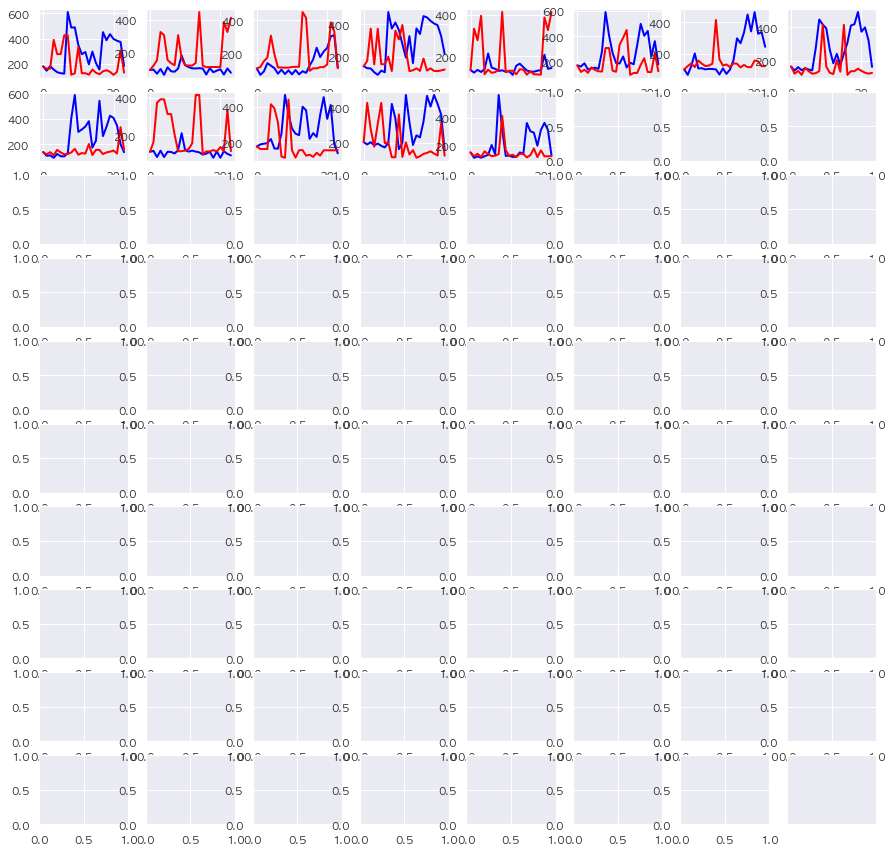

In [208]:
# visual
fig, axes = plt.subplots(10,8, figsize=(15,15))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

test_real = list()
test_predict = list()

power_info = 1
y = train_y.copy()

for i in range(0, round(len(test_X) / 24)):
    start_idx = 24 * i
    end_idx = (24 * (i + 1))
    
    real_pattern = test_X[end_idx-1][-23:]
    real_pattern = np.append(real_pattern, [test_y[end_idx-1]])
    
    test_real.append(real_pattern)
    print("real_pattern:",real_pattern)
    
    predict_pattern = test_X[start_idx+power_info][-power_info:].tolist()

    for p in range(start_idx + power_info, end_idx):
        result = model.predict_classes([test_X[p].tolist()])
        predict_pattern.append(y[result[0]])
    test_predict.append(predict_pattern)
    
    print("predict_pattern:", predict_pattern)

for pi in range(0, len(test_real)):
    sns.lineplot(data=test_real[pi], label="real", lw=2, color="blue", ax=axes[int(pi / 8)][pi % 8], legend=False)
    sns.lineplot(data=test_predict[pi], label="predict", lw=2, color="red", ax=axes[int(pi / 8)][pi % 8], legend=False)

real_pattern: [181. 147. 183. 156. 135. 127. 124. 611. 488. 490. 350. 277. 295. 197.
 298. 208. 156. 452. 388. 436. 398. 384. 374. 185.]


/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


predict_pattern: [181.0, 147.0, 183.0, 156.0, 135.0, 278.0, 427.0, 427.0, 115.0, 126.0, 334.0, 127.0, 127.0, 115.0, 156.0, 131.0, 119.0, 142.0, 151.0, 138.0, 114.0, 138.0, 308.0, 132.0]
real_pattern: [ 95.  97.  72. 101.  65. 111.  87.  84. 104. 183. 124. 112. 105. 104.
 106. 104.  67. 106.  81.  91.  99.  67. 104.  78.]
predict_pattern: [95.0, 97.0, 72.0, 101.0, 65.0, 156.0, 136.0, 124.0, 308.0, 164.0, 124.0, 122.0, 122.0, 138.0, 449.0, 121.0, 112.0, 113.0, 113.0, 113.0, 112.0, 388.0, 327.0, 414.0]
real_pattern: [112.  74.  94. 144. 129. 114.  81. 105.  79. 101.  77. 103.  77.  96.
  86. 129. 166. 236. 180. 213. 235. 304. 311. 116.]
predict_pattern: [112.0, 74.0, 94.0, 144.0, 129.0, 197.0, 118.0, 118.0, 117.0, 117.0, 121.0, 122.0, 122.0, 449.0, 414.0, 98.0, 113.0, 113.0, 120.0, 120.0, 136.0, 388.0, 334.0, 114.0]
real_pattern: [144. 132. 130. 107.  91. 117. 107. 475. 374. 411. 365. 279. 196. 328.
 163. 375. 341. 450. 442. 421. 405. 395. 329. 219.]
predict_pattern: [144.0, 132.0, 130.0,

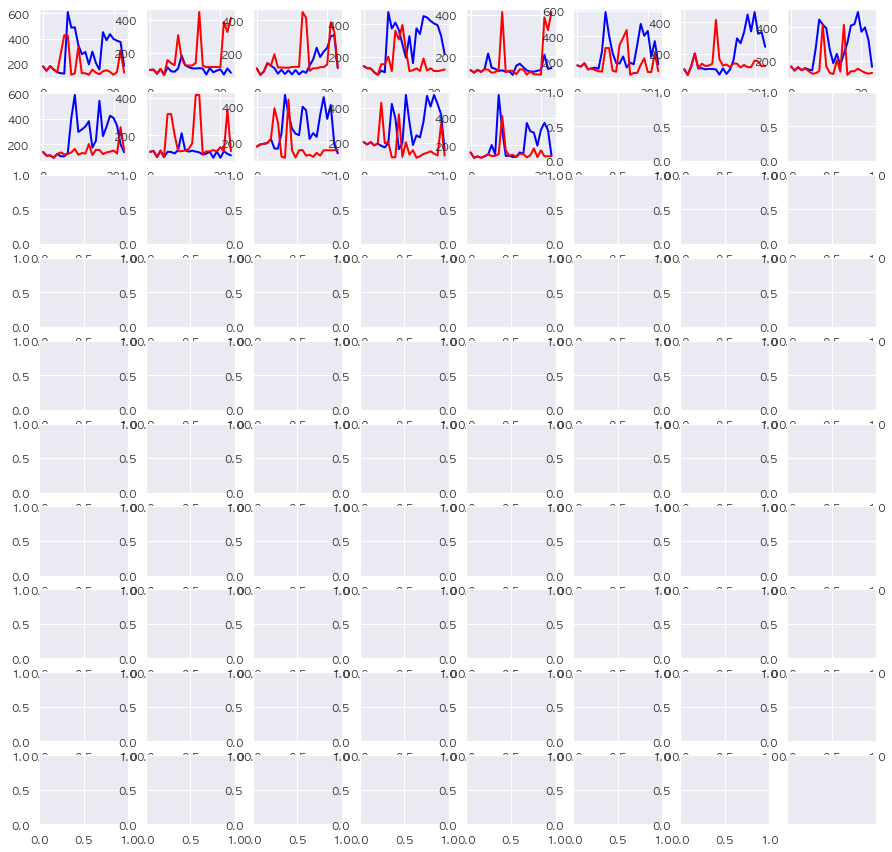

In [209]:
# visual
fig, axes = plt.subplots(10,8, figsize=(15,15))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

test_real = list()
test_predict = list()

power_info = 5
y = train_y.copy()

for i in range(0, round(len(test_X) / 24)):
    start_idx = 24 * i
    end_idx = (24 * (i + 1))
    
    real_pattern = test_X[end_idx-1][-23:]
    real_pattern = np.append(real_pattern, [test_y[end_idx-1]])
    
    test_real.append(real_pattern)
    print("real_pattern:",real_pattern)
    
    predict_pattern = test_X[start_idx+power_info][-power_info:].tolist()

    for p in range(start_idx + power_info, end_idx):
        result = model.predict_classes([test_X[p].tolist()])
        predict_pattern.append(y[result[0]])
    test_predict.append(predict_pattern)
    
    print("predict_pattern:", predict_pattern)

for pi in range(0, len(test_real)):
    sns.lineplot(data=test_real[pi], label="real", lw=2, color="blue", ax=axes[int(pi / 8)][pi % 8], legend=False)
    sns.lineplot(data=test_predict[pi], label="predict", lw=2, color="red", ax=axes[int(pi / 8)][pi % 8], legend=False)

real_pattern: [181. 147. 183. 156. 135. 127. 124. 611. 488. 490. 350. 277. 295. 197.
 298. 208. 156. 452. 388. 436. 398. 384. 374. 185.]


/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


predict_pattern: [181.0, 147.0, 183.0, 156.0, 135.0, 127.0, 124.0, 611.0, 488.0, 490.0, 334.0, 127.0, 127.0, 115.0, 156.0, 131.0, 119.0, 142.0, 151.0, 138.0, 114.0, 138.0, 308.0, 132.0]
real_pattern: [ 95.  97.  72. 101.  65. 111.  87.  84. 104. 183. 124. 112. 105. 104.
 106. 104.  67. 106.  81.  91.  99.  67. 104.  78.]
predict_pattern: [95.0, 97.0, 72.0, 101.0, 65.0, 111.0, 87.0, 84.0, 104.0, 183.0, 124.0, 122.0, 122.0, 138.0, 449.0, 121.0, 112.0, 113.0, 113.0, 113.0, 112.0, 388.0, 327.0, 414.0]
real_pattern: [112.  74.  94. 144. 129. 114.  81. 105.  79. 101.  77. 103.  77.  96.
  86. 129. 166. 236. 180. 213. 235. 304. 311. 116.]
predict_pattern: [112.0, 74.0, 94.0, 144.0, 129.0, 114.0, 81.0, 105.0, 79.0, 101.0, 121.0, 122.0, 122.0, 449.0, 414.0, 98.0, 113.0, 113.0, 120.0, 120.0, 136.0, 388.0, 334.0, 114.0]
real_pattern: [144. 132. 130. 107.  91. 117. 107. 475. 374. 411. 365. 279. 196. 328.
 163. 375. 341. 450. 442. 421. 405. 395. 329. 219.]
predict_pattern: [144.0, 132.0, 130.0, 107

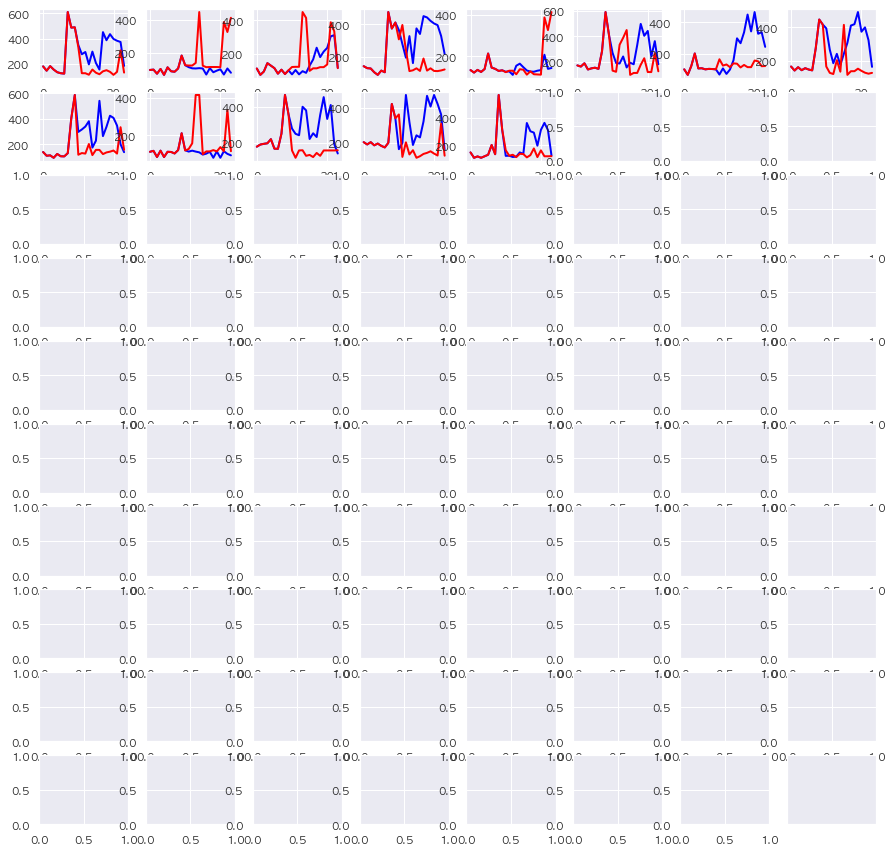

In [210]:
# visual
fig, axes = plt.subplots(10,8, figsize=(15,15))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

test_real = list()
test_predict = list()

power_info = 10
y = train_y.copy()

for i in range(0, round(len(test_X) / 24)):
    start_idx = 24 * i
    end_idx = (24 * (i + 1))
    
    real_pattern = test_X[end_idx-1][-23:]
    real_pattern = np.append(real_pattern, [test_y[end_idx-1]])
    
    test_real.append(real_pattern)
    print("real_pattern:",real_pattern)
    
    predict_pattern = test_X[start_idx+power_info][-power_info:].tolist()

    for p in range(start_idx + power_info, end_idx):
        result = model.predict_classes([test_X[p].tolist()])
        predict_pattern.append(y[result[0]])
    test_predict.append(predict_pattern)
    
    print("predict_pattern:", predict_pattern)

for pi in range(0, len(test_real)):
    sns.lineplot(data=test_real[pi], label="real", lw=2, color="blue", ax=axes[int(pi / 8)][pi % 8], legend=False)
    sns.lineplot(data=test_predict[pi], label="predict", lw=2, color="red", ax=axes[int(pi / 8)][pi % 8], legend=False)

real_pattern: [181. 147. 183. 156. 135. 127. 124. 611. 488. 490. 350. 277. 295. 197.
 298. 208. 156. 452. 388. 436. 398. 384. 374. 185.]


/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


predict_pattern: [181.0, 147.0, 183.0, 156.0, 135.0, 127.0, 124.0, 611.0, 488.0, 490.0, 350.0, 277.0, 295.0, 197.0, 298.0, 131.0, 119.0, 142.0, 151.0, 138.0, 114.0, 138.0, 308.0, 132.0]
real_pattern: [ 95.  97.  72. 101.  65. 111.  87.  84. 104. 183. 124. 112. 105. 104.
 106. 104.  67. 106.  81.  91.  99.  67. 104.  78.]
predict_pattern: [95.0, 97.0, 72.0, 101.0, 65.0, 111.0, 87.0, 84.0, 104.0, 183.0, 124.0, 112.0, 105.0, 104.0, 106.0, 121.0, 112.0, 113.0, 113.0, 113.0, 112.0, 388.0, 327.0, 414.0]
real_pattern: [112.  74.  94. 144. 129. 114.  81. 105.  79. 101.  77. 103.  77.  96.
  86. 129. 166. 236. 180. 213. 235. 304. 311. 116.]
predict_pattern: [112.0, 74.0, 94.0, 144.0, 129.0, 114.0, 81.0, 105.0, 79.0, 101.0, 77.0, 103.0, 77.0, 96.0, 86.0, 98.0, 113.0, 113.0, 120.0, 120.0, 136.0, 388.0, 334.0, 114.0]
real_pattern: [144. 132. 130. 107.  91. 117. 107. 475. 374. 411. 365. 279. 196. 328.
 163. 375. 341. 450. 442. 421. 405. 395. 329. 219.]
predict_pattern: [144.0, 132.0, 130.0, 107.0, 

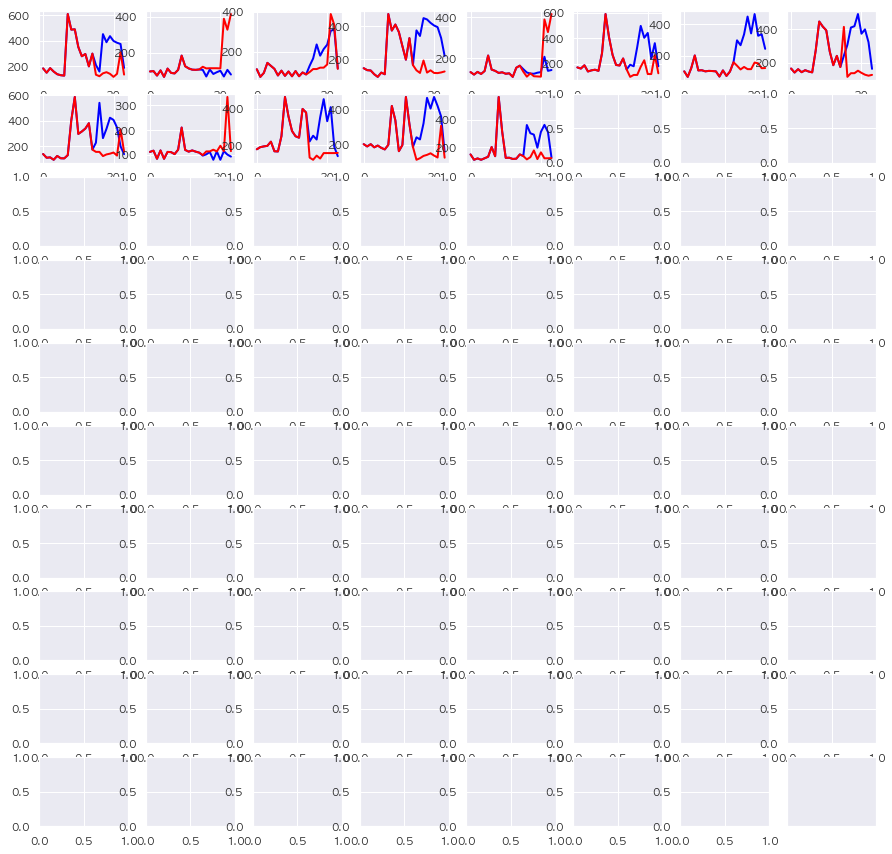

In [211]:
# visual
fig, axes = plt.subplots(10,8, figsize=(15,15))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

test_real = list()
test_predict = list()

power_info = 15
y = train_y.copy()

for i in range(0, round(len(test_X) / 24)):
    start_idx = 24 * i
    end_idx = (24 * (i + 1))
    
    real_pattern = test_X[end_idx-1][-23:]
    real_pattern = np.append(real_pattern, [test_y[end_idx-1]])
    
    test_real.append(real_pattern)
    print("real_pattern:",real_pattern)
    
    predict_pattern = test_X[start_idx+power_info][-power_info:].tolist()

    for p in range(start_idx + power_info, end_idx):
        result = model.predict_classes([test_X[p].tolist()])
        predict_pattern.append(y[result[0]])
    test_predict.append(predict_pattern)
    
    print("predict_pattern:", predict_pattern)

for pi in range(0, len(test_real)):
    sns.lineplot(data=test_real[pi], label="real", lw=2, color="blue", ax=axes[int(pi / 8)][pi % 8], legend=False)
    sns.lineplot(data=test_predict[pi], label="predict", lw=2, color="red", ax=axes[int(pi / 8)][pi % 8], legend=False)